In [ ]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [17]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import anndata as ad

import varseek as vk
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
data_dir = os.path.join(RLSRWP_2025_dir, "data")

In [ ]:
# #!!! dummy data to be erased

# # Define shared dimensions
# n_obs = 5
# n_vars = 50

# # Create shared obs and var
# obs = pd.DataFrame(index=[f"cell{i}" for i in range(n_obs)])
# variant_var = pd.DataFrame(index=[f"vcrs{j}" for j in range(n_vars)])
# variant_var["variant_header"] = variant_var.index
# gene_var = pd.DataFrame(index=[f"gene{j}" for j in range(n_vars)])

# # Generate random matrices
# X_vcrs = np.random.randint(0, 101, size=(n_obs, n_vars))
# X_reference = np.random.randint(0, 101, size=(n_obs, n_vars))
# X_genotype = np.random.choice([0, 1, 2], size=(n_obs, n_vars))

# # Create the AnnData objects
# adata_vcrs = ad.AnnData(X=X_vcrs, obs=obs.copy(), var=variant_var.copy())
# adata_reference = ad.AnnData(X=X_reference, obs=obs.copy(), var=gene_var.copy())
# adata_genotype = ad.AnnData(X=X_genotype, obs=obs.copy(), var=variant_var.copy())

In [ ]:
sequencing_data_out_base = os.path.join(data_dir, "geuvadis_data_base")
geuvadis_reference_files_dir = os.path.join(data_dir, "reference", "geuvadis")
geuvadis_genotype_true_adata = os.path.join(geuvadis_reference_files_dir, "genotypes_adata_true.h5ad")
reference_genome_t2g = os.path.join(data_dir, "reference", "ensembl_grch37_release113", "t2g.txt")

adata_combined_path_reference_genome = os.path.join(sequencing_data_out_base, "adata_reference_genome_combined.h5ad")

w_and_k_list_of_dicts = [
    {"w": 27, "k": 31},
    {"w": 37, "k": 41},
    {"w": 47, "k": 51},
]

sample_index = 1  # sample to focus on - lowest is 1 (index in adata)
min_counts = 1

out_dir = os.path.join(data_dir, "geuvadis_analysis")

In [49]:
if not os.path.isfile(adata_combined_path_reference_genome):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_reference_genome"], output_file_name=adata_combined_path_reference_genome)
if not os.path.isfile(geuvadis_genotype_true_adata):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_genotype"], output_file_name=geuvadis_genotype_true_adata)

adata_reference = ad.read_h5ad(adata_combined_path_reference_genome)
adata_genotype = ad.read_h5ad(geuvadis_genotype_true_adata)

os.makedirs(out_dir, exist_ok=True)

In [50]:
#!!! ensure that this file is downloadable etc
variants_transcriptome_df = pd.read_parquet("/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/variants_transcriptome.parquet")
variants_transcriptome_df['variant_header_cdna'] = variants_transcriptome_df['transcript_ID'] + ":" + variants_transcriptome_df['variant_cdna']
adata_genotype.var = adata_genotype.var.merge(variants_transcriptome_df[["variant_header", "variant_header_cdna"]], how="left", on="variant_header")
adata_genotype.var.rename(columns={"variant_header": "variant_header_cds", "variant_header_cdna": "variant_header"}, inplace=True)

In [81]:
vcf = pd.read_parquet("/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/1kg_phase1_all_preliminary_vcf_exons.parquet")
vcf.head()

,CHROM,POS,ID,REF,ALT
0,1,13302,rs180734498,C,T
1,1,13327,rs144762171,G,C
2,1,63276,rs185977555,G,A
3,1,63297,rs188886746,G,A
4,1,63671,rs116440577,G,A


## Plot Venn diagrams for my k-series to determine the best variant matrix to use

In [ ]:
# import pysam
# import pandas as pd

# vcf_path_preliminary = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/1kg_phase1_all_preliminary_exons.vcf.gz"
# vcf_path_true = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/1kg_phase1_all_true.vcf.gz"
# sample = "0_HG00377"

# vcf_preliminary = pysam.VariantFile(vcf_path_preliminary)
# vcf_true = pysam.VariantFile(vcf_path_true)

# # Check sample names
# if sample not in vcf_preliminary.header.samples:
#     raise ValueError("Sample sample not found in VCF")

# variants_possessed_by_this_sample = set()
# for rec_preliminary, rec_true in zip(vcf_preliminary, vcf_true):
#     if rec_preliminary.ref == rec_true.ref:
#         sample_homozygous_ref = rec_preliminary.samples[sample].get("GT") == (0, 0)
#     else:
#         sample_homozygous_ref = rec_preliminary.samples[sample].get("GT") == (1, 1)
#     if not sample_homozygous_ref:
#         variants_possessed_by_this_sample.add(rec_preliminary.id)


[W::vcf_parse] Contig '1' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '2' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '3' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '4' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '5' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '6' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '7' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '8' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '9' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '10' is not defined in the header. (Quick workaroun

KeyboardInterrupt: 

k=31
Sample HG00377
First 1000 variants_true: ['ENST00000000442:c.263C>A', 'ENST00000000442:c.264C>G', 'ENST00000001008:c.1186G>A', 'ENST00000001008:c.1253C>G', 'ENST00000001008:c.1351C>G', 'ENST00000001008:c.641C>A', 'ENST00000001008:c.752C>A', 'ENST00000002125:c.155C>A', 'ENST00000002125:c.227A>C', 'ENST00000002125:c.886C>A', 'ENST00000002125:c.985C>A', 'ENST00000002165:c.1417C>T', 'ENST00000002165:c.1445G>C', 'ENST00000002829:c.1066C>A', 'ENST00000002829:c.1322C>G', 'ENST00000002829:c.496C>A', 'ENST00000002829:c.521C>A', 'ENST00000002829:c.527G>A', 'ENST00000002829:c.925C>G', 'ENST00000003084:c.1328C>A', 'ENST00000003084:c.1540G>A', 'ENST00000003084:c.1585A>G', 'ENST00000003084:c.1620G>A', 'ENST00000003084:c.1655T>A', 'ENST00000003084:c.1789C>G', 'ENST00000003084:c.1923C>G', 'ENST00000003084:c.2134C>A', 'ENST00000003084:c.223C>A', 'ENST00000003084:c.2377C>A', 'ENST00000003084:c.2505A>C', 'ENST00000003084:c.2694T>A', 'ENST00000003084:c.269C>A', 'ENST00000003084:c.279A>C', 'ENST000000

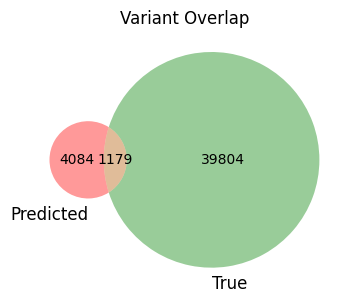

------------------------


In [ ]:
# TODO: I currently ran vk ref with merge_identical=False, but in the future, I would like to do this with True, resolve merged headers with reference genome alignment, and then filter out whichever merged headers remain
def plot_variant_overlap(adata_vcrs_path, adata_genotype_path, sample_index=1, min_counts=None, out_path=None):
    if isinstance(adata_vcrs_path, str):
        adata_vcrs = ad.read_h5ad(adata_vcrs_path)
    elif isinstance(adata_vcrs_path, ad.AnnData):
        adata_vcrs = adata_vcrs_path.copy()
    else:
        raise ValueError("adata_vcrs_path must be a string or an AnnData object.")
    if "vcrs_header" in adata_vcrs.var.columns:
        adata_vcrs.var["variant_header"] = adata_vcrs.var["vcrs_header"].copy()
    if "variant_header" not in adata_vcrs.var.columns:
        adata_vcrs.var["variant_header"] = adata_vcrs.var.index.copy()

    if isinstance(adata_genotype_path, str):
        adata_genotype = ad.read_h5ad(adata_genotype_path)
    elif isinstance(adata_genotype_path, ad.AnnData):
        adata_genotype = adata_genotype_path.copy()
    else:
        raise ValueError("adata_genotype_path must be a string or an AnnData object.")
    
    # Select only the sample_index'th sample
    sample_title = adata_vcrs.obs.iloc[sample_index]['sample_title']
    print(f"Sample {sample_title}")
    adata_genotype.obs['sample_title'] = adata_genotype.obs.index.copy().str.slice(2)
    if sample_title not in set(adata_genotype.obs['sample_title']):
        raise ValueError(f"Sample title {sample_title} not found in adata_genotype.")
    
    adata_vcrs = adata_vcrs[sample_index, :]
    adata_genotype = adata_genotype[adata_genotype.obs['sample_title'] == sample_title].copy()

    if min_counts is not None:
        adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)
    
    variants_all = set(adata_vcrs.var["variant_header"])

    # Filter adata_vcrs: keep only columns where the value in the first row is not 0
    nonzero_vcrs_cols = adata_vcrs.X[0] > 0
    adata_vcrs = adata_vcrs[:, nonzero_vcrs_cols]
    variants_predicted = set(adata_vcrs.var["variant_header"])

    # Filter adata_genotype: keep only columns where the value in the first row is not 0
    nonzero_genotype_cols = adata_genotype.X[0] > 0
    adata_genotype = adata_genotype[:, nonzero_genotype_cols]
    variants_true = set(adata_genotype.var["variant_header"])

    # ensure no version numbers on Ensembl transcript IDs
    variants_predicted = {re.sub(r'(ENST\d+)\.\d+', r'\1', v) for v in variants_predicted}
    variants_true = {re.sub(r'(ENST\d+)\.\d+', r'\1', v) for v in variants_true}

    print(f"First 1000 variants_true: {sorted(list(variants_true))[:1000]}")
    print(f"First 1000 variants_predicted: {sorted(list(variants_predicted))[:1000]}")

    TP = len(variants_predicted & variants_true)
    FP = len(variants_predicted - variants_true)
    FN = len(variants_true - variants_predicted)
    TN = len(variants_all - variants_true - variants_predicted)

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0

    print(f"Number of variants_predicted: {len(variants_predicted)}")
    print(f"Number of variants_true: {len(variants_true)}")
    print(f"Number of variants_all: {len(variants_all)}")
    print(f"Number of TP: {TP}")
    print(f"Number of FP: {FP}")
    print(f"Number of FN: {FN}")
    print(f"Number of TN: {TN}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")

    plt.figure(figsize=(4, 4))
    venn2([variants_predicted, variants_true], set_labels=('Predicted', 'True'))
    plt.title("Variant Overlap")
    if out_path:
        plt.savefig(out_path, dpi=300)
    plt.show()

for w_and_k_dict in w_and_k_list_of_dicts:
    w, k = w_and_k_dict["w"], w_and_k_dict["k"]
    adata_combined_path_vcrs = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w{w}_k{k}.h5ad")
    if not os.path.isfile(adata_combined_path_vcrs):
        vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w{w}_k{k}"], output_file_name=adata_combined_path_vcrs)
    
    print(f"k={k}")
    venn_out_path = os.path.join(out_dir, f"variant_overlap_sample_{sample_index}_w{w}_k{k}.png")
    plot_variant_overlap(adata_combined_path_vcrs, adata_genotype, sample_index=4, out_path=venn_out_path, min_counts=min_counts)
    print("------------------------")

    break

k=31
Sample HG00377
First 1000 variants_true: ['ENST00000000442:c.263C>A', 'ENST00000000442:c.264C>G', 'ENST00000001008:c.1186G>A', 'ENST00000001008:c.1253C>G', 'ENST00000001008:c.1351C>G', 'ENST00000001008:c.641C>A', 'ENST00000001008:c.752C>A', 'ENST00000002125:c.155C>A', 'ENST00000002125:c.227A>C', 'ENST00000002125:c.886C>A', 'ENST00000002125:c.985C>A', 'ENST00000002165:c.1417C>T', 'ENST00000002165:c.1445G>C', 'ENST00000002829:c.1066C>A', 'ENST00000002829:c.1322C>G', 'ENST00000002829:c.496C>A', 'ENST00000002829:c.521C>A', 'ENST00000002829:c.527G>A', 'ENST00000002829:c.925C>G', 'ENST00000003084:c.1328C>A', 'ENST00000003084:c.1540G>A', 'ENST00000003084:c.1585A>G', 'ENST00000003084:c.1620G>A', 'ENST00000003084:c.1655T>A', 'ENST00000003084:c.1789C>G', 'ENST00000003084:c.1923C>G', 'ENST00000003084:c.2134C>A', 'ENST00000003084:c.223C>A', 'ENST00000003084:c.2377C>A', 'ENST00000003084:c.2505A>C', 'ENST00000003084:c.2694T>A', 'ENST00000003084:c.269C>A', 'ENST00000003084:c.279A>C', 'ENST000000

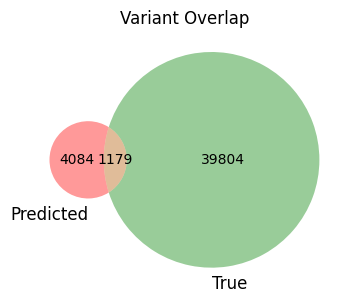

------------------------


In [70]:
# TODO: I currently ran vk ref with merge_identical=False, but in the future, I would like to do this with True, resolve merged headers with reference genome alignment, and then filter out whichever merged headers remain
def plot_variant_overlap(adata_vcrs_path, adata_genotype_path, sample_index=1, min_counts=None, out_path=None):
    if isinstance(adata_vcrs_path, str):
        adata_vcrs = ad.read_h5ad(adata_vcrs_path)
    elif isinstance(adata_vcrs_path, ad.AnnData):
        adata_vcrs = adata_vcrs_path.copy()
    else:
        raise ValueError("adata_vcrs_path must be a string or an AnnData object.")
    if "vcrs_header" in adata_vcrs.var.columns:
        adata_vcrs.var["variant_header"] = adata_vcrs.var["vcrs_header"].copy()
    if "variant_header" not in adata_vcrs.var.columns:
        adata_vcrs.var["variant_header"] = adata_vcrs.var.index.copy()

    if isinstance(adata_genotype_path, str):
        adata_genotype = ad.read_h5ad(adata_genotype_path)
    elif isinstance(adata_genotype_path, ad.AnnData):
        adata_genotype = adata_genotype_path.copy()
    else:
        raise ValueError("adata_genotype_path must be a string or an AnnData object.")
    
    # Select only the sample_index'th sample
    sample_title = adata_vcrs.obs.iloc[sample_index]['sample_title']
    print(f"Sample {sample_title}")
    adata_genotype.obs['sample_title'] = adata_genotype.obs.index.copy().str.slice(2)
    if sample_title not in set(adata_genotype.obs['sample_title']):
        raise ValueError(f"Sample title {sample_title} not found in adata_genotype.")
    
    adata_vcrs = adata_vcrs[sample_index, :]
    adata_genotype = adata_genotype[adata_genotype.obs['sample_title'] == sample_title].copy()

    if min_counts is not None:
        adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)
    
    variants_all = set(adata_vcrs.var["variant_header"])

    # Filter adata_vcrs: keep only columns where the value in the first row is not 0
    nonzero_vcrs_cols = adata_vcrs.X[0] > 0
    adata_vcrs = adata_vcrs[:, nonzero_vcrs_cols]
    variants_predicted = set(adata_vcrs.var["variant_header"])

    # Filter adata_genotype: keep only columns where the value in the first row is not 0
    nonzero_genotype_cols = adata_genotype.X[0] > 0
    adata_genotype = adata_genotype[:, nonzero_genotype_cols]
    variants_true = set(adata_genotype.var["variant_header"])

    # ensure no version numbers on Ensembl transcript IDs
    variants_predicted = {re.sub(r'(ENST\d+)\.\d+', r'\1', v) for v in variants_predicted}
    variants_true = {re.sub(r'(ENST\d+)\.\d+', r'\1', v) for v in variants_true}

    print(f"First 1000 variants_true: {sorted(list(variants_true))[:1000]}")
    print(f"First 1000 variants_predicted: {sorted(list(variants_predicted))[:1000]}")

    TP = len(variants_predicted & variants_true)
    FP = len(variants_predicted - variants_true)
    FN = len(variants_true - variants_predicted)
    TN = len(variants_all - variants_true - variants_predicted)

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0

    print(f"Number of variants_predicted: {len(variants_predicted)}")
    print(f"Number of variants_true: {len(variants_true)}")
    print(f"Number of variants_all: {len(variants_all)}")
    print(f"Number of TP: {TP}")
    print(f"Number of FP: {FP}")
    print(f"Number of FN: {FN}")
    print(f"Number of TN: {TN}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")

    plt.figure(figsize=(4, 4))
    venn2([variants_predicted, variants_true], set_labels=('Predicted', 'True'))
    plt.title("Variant Overlap")
    if out_path:
        plt.savefig(out_path, dpi=300)
    plt.show()

for w_and_k_dict in w_and_k_list_of_dicts:
    w, k = w_and_k_dict["w"], w_and_k_dict["k"]
    adata_combined_path_vcrs = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w{w}_k{k}.h5ad")
    if not os.path.isfile(adata_combined_path_vcrs):
        vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w{w}_k{k}"], output_file_name=adata_combined_path_vcrs)
    
    print(f"k={k}")
    venn_out_path = os.path.join(out_dir, f"variant_overlap_sample_{sample_index}_w{w}_k{k}.png")
    plot_variant_overlap(adata_combined_path_vcrs, adata_genotype, sample_index=4, out_path=venn_out_path)
    print("------------------------")

    break

## Based on this, I will choose k=51

In [ ]:
w, k = 47, 51
adata_combined_path_vcrs_final = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_final_w{w}_k{k}.h5ad")
if not os.path.isfile(adata_combined_path_vcrs_final):
    vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w{w}_k{k}"], output_file_name=adata_combined_path_vcrs_final)

adata_vcrs = ad.read_h5ad(adata_combined_path_vcrs_final)
if min_counts is not None:
    adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)

adata_vcrs.var.rename(columns={"vcrs_header": "variant_header"}, inplace=True)
adata_vcrs.var[["transcript_ID", "variant"]] = adata_vcrs.var["variant_header"].str.split(":", expand=True)
t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
adata_vcrs.var["gene"] = adata_vcrs.var["transcript_ID"].map(t2g_dict)

In [ ]:
# Select only the sample_index'th sample
adata_vcrs = adata_vcrs[:sample_index, :]
adata_reference = adata_reference[:sample_index, :]
adata_genotype = adata_genotype[:sample_index, :]

# Filter adata_vcrs: keep only columns where the value in the sample_index'th row is not 0
nonzero_genotype_cols = adata_genotype.X[0] != 0
adata_genotype = adata_genotype[:, nonzero_genotype_cols]
variants_true = set(adata_genotype.var["variant_header"])

# filter adata_vcrs to only keep those present in variants_true
adata_vcrs = adata_vcrs[:, adata_vcrs.var['variant_header'].isin(variants_true)]

# add 1D count "matrix" as a column to adata.var
adata_vcrs.var["variant_counts"] = adata_vcrs.X[0]
adata_reference.var["gene_counts"] = adata_reference.X[0]
adata_genotype.var["genotype"] = adata_genotype.X[0]

# Merge adata_reference.var into adata_vcrs by gene
adata_vcrs.var = adata_vcrs.var.merge(
    adata_reference.var[["gene_counts"]],
    left_on="gene",
    right_index=True,
    how="left",
)

# Merge genotype into var by variant header
adata_vcrs.var = adata_vcrs.var.merge(
    adata_genotype.var[["variant_header", "genotype"]],
    on="variant_header",
    how="left",
)

## Scatterplot time

In [ ]:
scatterplot_df = adata_vcrs.var[["variant_counts", "gene_counts", "genotype"]].copy()
scatterplot_df["genotype"] = scatterplot_df["genotype"].astype("category")
scatterplot_df["genotype"] = scatterplot_df["genotype"].cat.rename_categories({0: "homozygous_ref", 1: "heterozygous", 2: "homozygous_alt"})

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=scatterplot_df,
    x="variant_counts",
    y="gene_counts",
    hue="genotype",
    palette="Set2",
    s=80  # adjust marker size
)

plt.title("Variant vs Gene Counts by Genotype")
plt.xlabel("Variant Counts")
plt.ylabel("Gene Counts")
plt.legend(title="Genotype")
plt.tight_layout()
out_file = os.path.join(out_dir, f"variant_vs_gene_counts_scatterplot_sample_{sample_index}_w{w}_k{k}.png")
plt.savefig(out_file, dpi=300)
plt.show()

In [1]:
import pandas as pd
variants_new = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/variants_transcriptome.parquet"
variants_old = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/geuvadis/variants_transcriptome_old_April24.parquet"

variants_new = pd.read_parquet(variants_new)
variants_old = pd.read_parquet(variants_old)

In [2]:
variant_headers_new = set(variants_new['variant_header'].tolist())
variant_headers_old = set(variants_old['variant_header'].tolist())

In [3]:
len(variant_headers_old)

204688

In [4]:
len(variant_headers_new)

203872

In [13]:
print(len(variant_headers_old & variant_headers_new))
print(len(variant_headers_old & variant_headers_new) / len(variant_headers_new))

166387
0.8161346334955266
